# Final Project Part 3: Develop A Prototype Model

### Predict the items that are most likely to be purchased together using Association Rule Mining

**Association Rule Mining** a method to use for determining relations among variables in large databases.

Three major metrics to evaluate the strength of association rules:

- **Support**: Refers to how frequently the itemset appears in the dataset. It signifies the popularity of an itemset.

> calculated as: support(X) = number of transaction in which item X appears / total number of transactions


- **Confidence**: It measures how often item Y appears in transactions that contain X. It measures the reliability of the rule. This method takes into account the popularity of item x.

> calculated as: confidence(X→Y) = (Transactions containing both (X and Y))/(Transactions containing X)

- **Lift**: It is the value that tells how likely item Y is bought together with item X. This method takes into account the popularity of the item Y.
If the value of lift is greater than 1 means that item Y is likely to be bought with X, while a value less than 1 implies that Y is unlikely to be bought if X is bought.

> calculated as: Lift(X→Y) = confidence(X→Y)/ support(Y)

#### Install Mlxtend

Mlxtend (machine learning extensions) is a Python library use to apply the apriori module and compute association rules.

**To install mlxtend run:**

> `pip install mlxtend`    
    

### Import the required libraries:  pandas, numpy, pyplot, mlxtend

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np 

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# association rules and apriori
from mlxtend.frequent_patterns import association_rules, apriori

%matplotlib inline

In [2]:
# Read Dataset
df= pd.read_csv('../../data/data_clean.csv')

df.head()

,month,order_date,order_time,user_id,order_id,product_id,category_id,category,product,brand,sales
0,April,2020-04-24,11:50:39,1.515916e+18,2294359932054536986,1515966223509089906,2.268105e+18,electronics,tablet,samsung,162.01
1,April,2020-04-24,11:50:39,1.515916e+18,2294359932054536986,1515966223509089906,2.268105e+18,electronics,tablet,samsung,162.01
2,April,2020-04-24,14:37:43,1.515916e+18,2294444024058086220,2273948319057183658,2.268105e+18,electronics,audio.headphone,huawei,77.52
3,April,2020-04-24,14:37:43,1.515916e+18,2294444024058086220,2273948319057183658,2.268105e+18,electronics,audio.headphone,huawei,77.52
4,April,2020-04-26,08:45:57,1.515916e+18,2295716521449619559,1515966223509261697,2.268105e+18,furniture,kitchen.table,maestro,39.33


### First Step: Binarization

Apriori module requires the data in a one-hot encoded.

One hot encoding is a process by which categorical variables are converted into a form of binary vectors.

In [3]:
# DataFrameGroupBy.size() to count the number of rows per group.
df = df.groupby(['order_id','product']).size().reset_index(name='count')

# Reshape the dataframe and converts the data into unstacked format using unstack()
# Use fillna() to replace the NAN values with 0. 
# 0 means those products haven’t bought together. 
market_basket = (df.groupby(['order_id', 'product'])['count'].sum().unstack().reset_index()
                 .fillna(0).set_index('order_id')) 


market_basket.head()

product,accessories.alarm,accessories.anti_freeze,accessories.compressor,accessories.player,accessories.radar,accessories.videoregister,audio.acoustic,audio.dictaphone,audio.headphone,audio.microphone,...,toys,trainer,trousers,tshirt,umbrella,universal.light,video.projector,video.tv,watering,weather_station
order_id,,,,,,,,,,,,,,,,,,,,,
2294359932054536986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2294444024058086220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2295716521449619559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2295740594749702229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2295902490203259134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Convert all numbers to either `1` or `0`. If the user has taken that item mark as `1` else `0` means the item is not taken.

In [4]:
# One hot encoding function
def encode_data(item_taken):
    if item_taken <= 0:
        return 0
    if item_taken >= 1:
        return 1
market_basket = market_basket.applymap(encode_data)

market_basket.head()

product,accessories.alarm,accessories.anti_freeze,accessories.compressor,accessories.player,accessories.radar,accessories.videoregister,audio.acoustic,audio.dictaphone,audio.headphone,audio.microphone,...,toys,trainer,trousers,tshirt,umbrella,universal.light,video.projector,video.tv,watering,weather_station
order_id,,,,,,,,,,,,,,,,,,,,,
2294359932054536986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2294444024058086220,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2295716521449619559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2295740594749702229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2295902490203259134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Second Step: Frequent Itemset Generation

Find out which items are frequently purchased together by applying the mlxtend `apriori` function to the dataset.


min_support is defined as the percentage of time that an itemset appears in the dataset.
Setting the support level too high could lead to low or no results and setting it too low could require an enormous amount of memory to process the data.

In [5]:
# Compute frequent itemsets using the Apriori()
# max_len = 3
frequent_itemsets = apriori(market_basket, min_support = 0.001, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.001559,(accessories.videoregister)
1,0.001281,(audio.acoustic)
2,0.057132,(audio.headphone)
3,0.003120,(audio.microphone)
4,0.008617,(bag)
...,...,...
150,0.002273,"(kitchen.oven, kitchen.hood, kitchen.washer)"
151,0.002028,"(kitchen.refrigerators, kitchen.hood, kitchen...."
152,0.001768,"(kitchen.oven, kitchen.refrigerators, kitchen...."
153,0.001697,"(kitchen.refrigerators, kitchen.washer, video.tv)"


### Final Step: Rule Generation 

The final step is to generate the rules using the Associations_rules() function to compute and prune association rules from the output of apriori().

Frequent if-then associations called association rules which consist of an antecedent (if) and a consequent (then).

> association_rules(df, metric='confidence', min_threshold=0.8, support_only=False)

Set a metric (lift or confidence) and a minimum threshold for the confidence level (min_threshold). Min_threshold can be taken as the percentage of confidence you want to return. If set as 1, you will only see rules with 100% certainty.

`Confidence` is an indication of how often the rule has been found to be true. 
Having confidence greater than or equal to the minimum confidence threshold is considered the strong association rule.

`Lift` If the value of lift is greater than 1 means that item Y is likely to be bought with X, while a value less than 1 means that there is a negative correlation within the itemset

`Leverage` measures the difference of X and Y appearing together in the data set.

`Conviction` compares the probability that X appears without Y if they were dependent on the actual frequency of the appearance of X without Y.

In [6]:
# Generate association rules for frequent_itemsets
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=.8)

# Create a column to count all left side item
rules['left_side_items'] = rules['antecedents'].apply(lambda x:len(x) )

# Sort values and show all the rules where the left-hand side consists of more than or equals to 1 item.
rules[rules['left_side_items']>=1].sort_values('confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,left_side_items
3,"(components.power_supply, components.motherboard)",(components.cpu),0.001151,0.010684,0.001024,0.889744,83.281377,0.001012,8.972870,2
5,"(kitchen.oven, kitchen.microwave)",(kitchen.hood),0.001382,0.023017,0.001228,0.888889,38.618158,0.001196,8.792844,2
0,"(components.hdd, components.motherboard)",(components.cpu),0.001160,0.010684,0.001024,0.882952,82.645641,0.001012,8.452203,2
1,"(components.memory, components.motherboard)",(components.cpu),0.001408,0.010684,0.001222,0.867925,81.239079,0.001207,7.490539,2
7,"(kitchen.oven, kitchen.refrigerators, kitchen....",(kitchen.hood),0.001768,0.023017,0.001467,0.829716,36.047375,0.001426,5.737378,3


**Observation:** 

Looking at the first row, the confidence level is 0.89 which shows that out of all the transactions that contain “motherboard” and “power supply”, 89 percent contain ‘CPU’ too.


The lift of 83 tells us that ‘CPU’ is 83 times more likely to be bought by the customers who purchase ‘motherboard’ and ‘power supply’ compared to the default likelihood sale of ‘CPU.’

#### Visualize the Association Rules using Heatmap

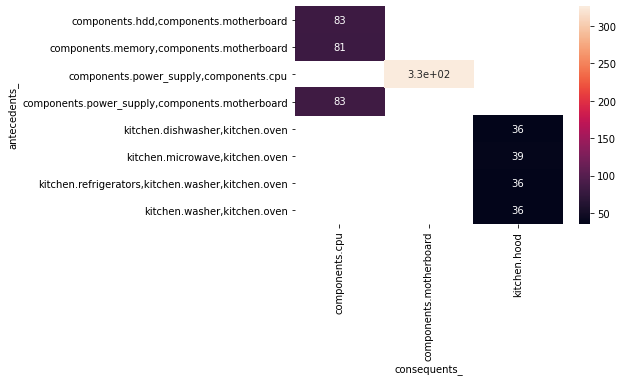

In [7]:
# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['left_side_items']>=1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

**CONCLUSION:**

By generating this rule will return the list of items that are frequently purchased with other items.


This information can be useful and applied in different ways such as:

1. Send a personalised email to show items related to previous purchases.

2. Generate product bundles and offer attractive rates.

3. Display the frequently bought together products on the product page or shopping cart page of the website.


This will lead to a great shopping experience and also a great way to increase product exposure and sales opportunity.
